In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import yfinance as yf

In [7]:
TICKER = 'TSLA'
START_DATE = '2015-07-01'
END_DATE = '2025-07-31'
data = yf.download(TICKER, start=START_DATE, end=END_DATE, auto_adjust=True)
tsla_close = data['Close'].ffill().bfill()
tsla_close.columns = ['Close']

[*********************100%***********************]  1 of 1 completed


In [8]:
train = tsla_close.loc[:'2023-12-31']
test = tsla_close.loc['2024-01-01':]

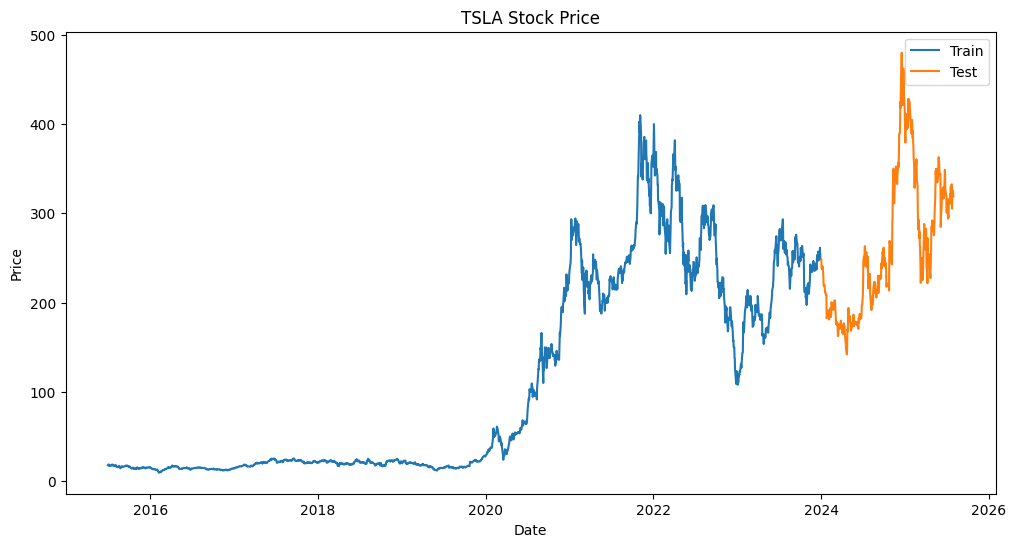

In [4]:
plt.figure(figsize=(12,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.title('TSLA Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [9]:
# ARIMA Model
import pmdarima as pm
arima_model = pm.auto_arima(train['Close'], seasonal=False, stepwise=True, suppress_warnings=True)
arima_forecast = arima_model.predict(n_periods=len(test))
arima_mae = mean_absolute_error(test['Close'], arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test['Close'], arima_forecast))
arima_mape = mean_absolute_percentage_error(test['Close'], arima_forecast)
print(f'ARIMA MAE: {arima_mae:.2f}, RMSE: {arima_rmse:.2f}, MAPE: {arima_mape:.4f}')

c:\Users\fikre\Portfolio-Management-Optimization\.venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\fikre\Portfolio-Management-Optimization\.venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\fikre\Portfolio-Management-Optimization\.venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\fikre\Portfolio-Management-Optimization\.venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\fikre\Portfolio-Management-Optimization\.venv\lib\site-packages\sklearn\utils\d

ARIMA MAE: 62.97, RMSE: 77.96, MAPE: 0.2409


c:\Users\fikre\Portfolio-Management-Optimization\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\fikre\Portfolio-Management-Optimization\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\fikre\Portfolio-Management-Optimization\.venv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


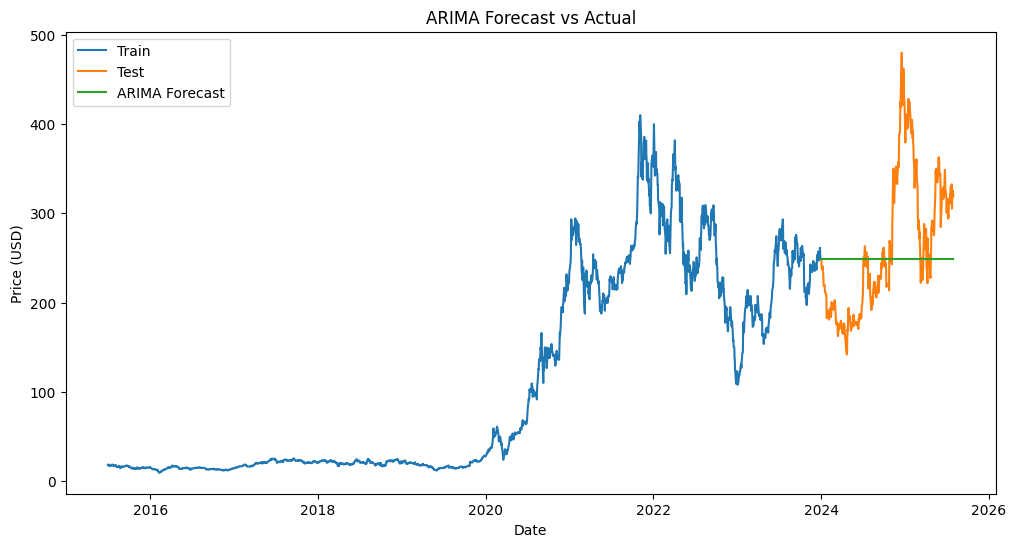

In [10]:
# Plot ARIMA forecast vs test
plt.figure(figsize=(12,6))
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Test')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [13]:
# LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Scale data
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

# Prepare sequences
def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 30
X_train, y_train = create_sequences(scaled_train, seq_length)
X_test, y_test = create_sequences(np.concatenate([scaled_train[-seq_length:], scaled_test]), seq_length)

# Build LSTM
model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(seq_length, 1)),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Forecast
lstm_pred = model.predict(X_test)
lstm_pred_rescaled = scaler.inverse_transform(lstm_pred)

# Align test set for evaluation
test_for_eval = test.iloc[:len(lstm_pred_rescaled)]
# Evaluation
lstm_mae = mean_absolute_error(test_for_eval['Close'], lstm_pred_rescaled)
lstm_rmse = np.sqrt(mean_squared_error(test_for_eval['Close'], lstm_pred_rescaled))
lstm_mape = mean_absolute_percentage_error(test_for_eval['Close'], lstm_pred_rescaled)
print(f'LSTM MAE: {lstm_mae:.2f}, RMSE: {lstm_rmse:.2f}, MAPE: {lstm_mape:.4f}')


Epoch 1/10


c:\Users\fikre\Portfolio-Management-Optimization\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0126
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0026
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0021
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0021
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0018
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0017
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0016
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0014
Epoch 9/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0015
Epoch 10/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0014
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
LSTM MAE: 13.63, RMSE: 17.92, MAPE: 0.0528


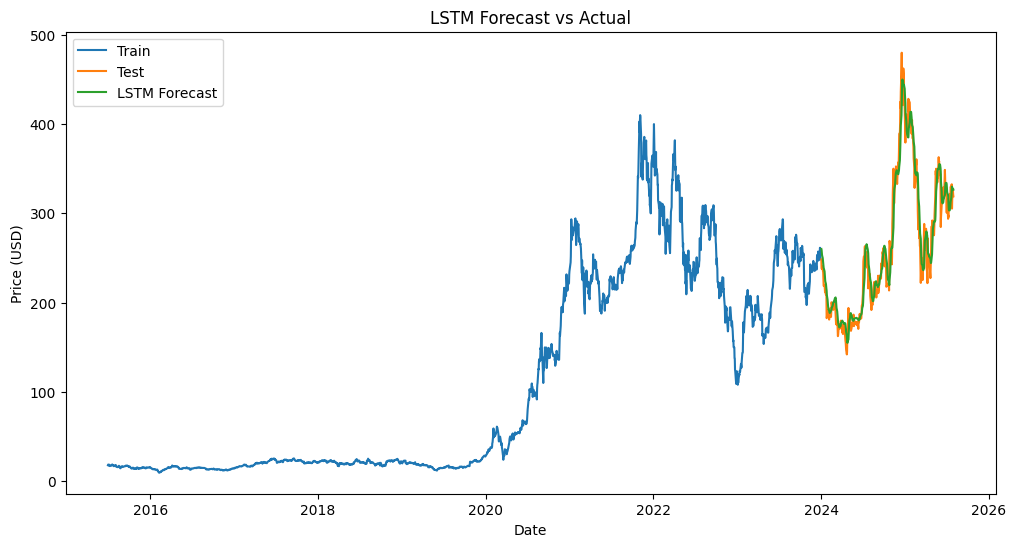

In [14]:
# Plot LSTM forecast vs test
plt.figure(figsize=(12,6))
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Test')
plt.plot(test_for_eval.index, lstm_pred_rescaled, label='LSTM Forecast')
plt.title('LSTM Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()
